<a href="https://colab.research.google.com/github/NgBlaze/HNGx/blob/main/Flood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:

import pandas as pd

# Load the dataset
data = pd.read_csv('lAGOS 2024-05-28 to 2024-07-19.csv')

# Inspect the first few rows of the dataset
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Summary statistics
print(data.describe())

# Check data types
print(data.dtypes)


    name             datetime  temp  feelslike   dew  humidity  precip  \
0  lAGOS  2024-05-28T00:00:00  82.4       90.9  77.0     83.79     0.0   
1  lAGOS  2024-05-28T01:00:00  81.0       88.2  77.3     88.34     0.0   
2  lAGOS  2024-05-28T02:00:00  80.6       87.1  77.0     88.84     0.0   
3  lAGOS  2024-05-28T03:00:00  82.0       90.5  77.5     86.11     0.0   
4  lAGOS  2024-05-28T04:00:00  80.4       86.9  77.4     90.68     0.0   

   precipprob preciptype  snow  ...  sealevelpressure  cloudcover  visibility  \
0         0.0        NaN   0.0  ...            1014.0        27.5         6.2   
1         0.0        NaN   NaN  ...            1014.0        57.1         6.2   
2         0.0        NaN   0.0  ...            1013.0        27.5         6.2   
3         0.0        NaN   0.0  ...            1011.9        31.7         6.8   
4         0.0        NaN   0.0  ...            1012.2        57.1         6.2   

   solarradiation  solarenergy  uvindex  severerisk        condition

In [15]:
# Separate numeric and non-numeric columns
numeric_cols = data.select_dtypes(include=['number']).columns
categorical_cols = data.select_dtypes(exclude=['number']).columns

# Fill missing values in numeric columns with the mean
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Fill missing values in categorical columns with mode
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Alternatively, use forward fill for categorical columns
# data[categorical_cols] = data[categorical_cols].fillna(method='ffill')

# Example for a specific categorical column
data['preciptype'].fillna(method='ffill', inplace=True)


In [16]:
# Convert 'datetime' to datetime type
data['datetime'] = pd.to_datetime(data['datetime'])


In [17]:
# Extract new features from datetime
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour


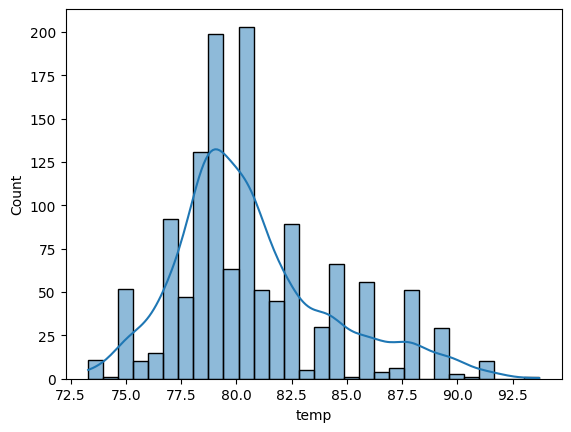

count    1272.000000
mean       80.700865
std         3.510352
min        73.300000
25%        78.600000
50%        80.150000
75%        82.400000
max        93.700000
Name: temp, dtype: float64


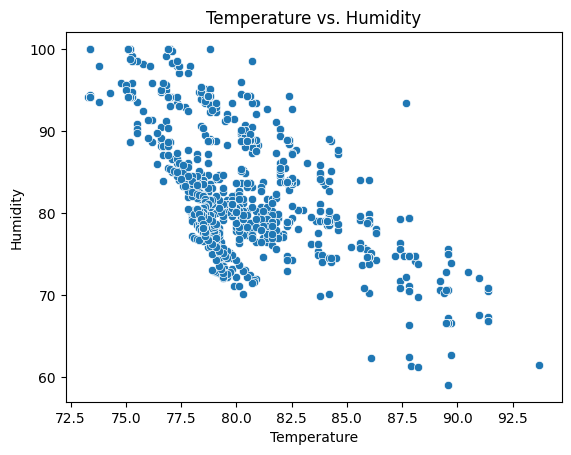

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of temperature vs. humidity
sns.scatterplot(x='temp', y='humidity', data=data)
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.title('Temperature vs. Humidity')
plt.show()

# Select only numeric columns for the correlation matrix
numeric_data = data.select_dtypes(include=['number'])




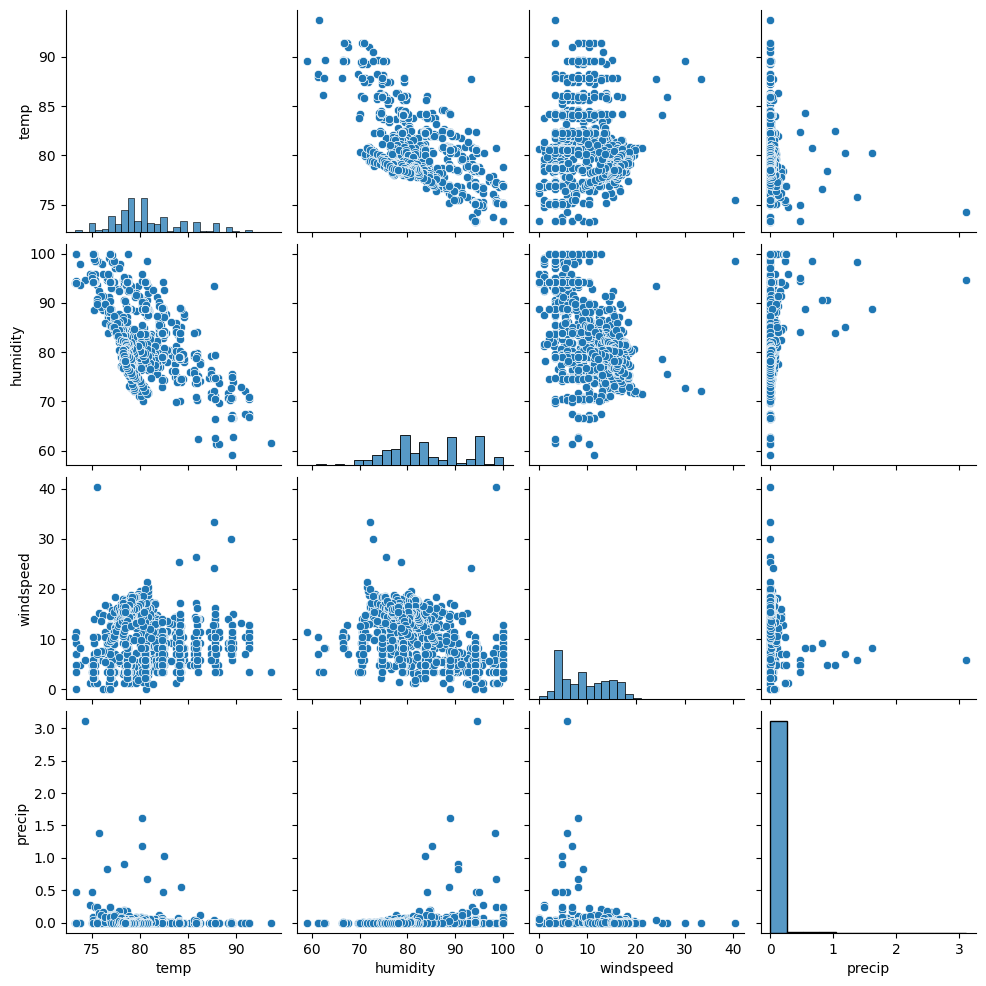

In [25]:
# Pairplot for multiple variables
sns.pairplot(data[['temp', 'humidity', 'windspeed', 'precip']])
plt.show()


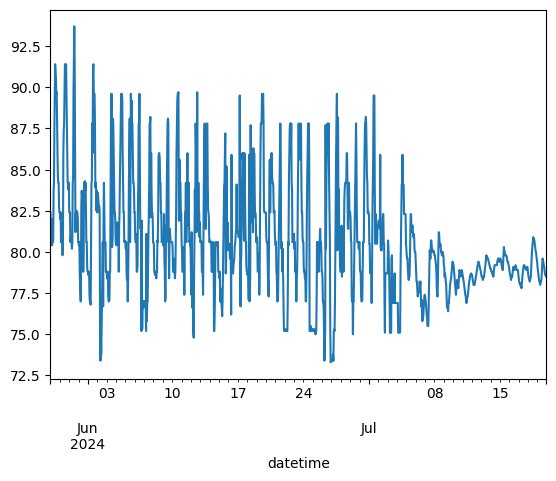

In [26]:
# Plot temperature over time
data.set_index('datetime')['temp'].plot()
plt.show()


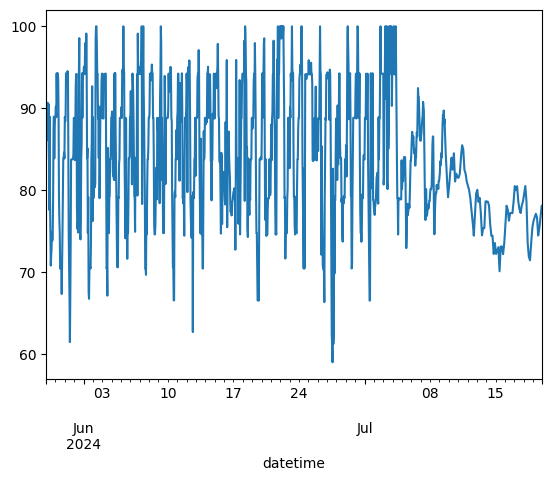

In [27]:
# Plot temperature over time
data.set_index('datetime')['humidity'].plot()
plt.show()


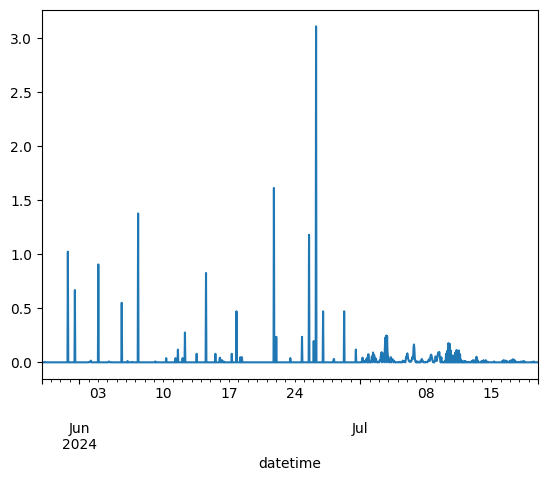

In [28]:
# Plot temperature over time
data.set_index('datetime')['precip'].plot()
plt.show()


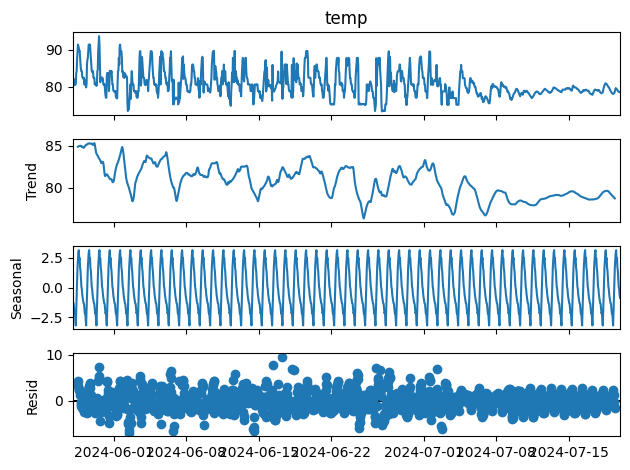

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data.set_index('datetime')['temp'], model='additive')
result.plot()
plt.show()


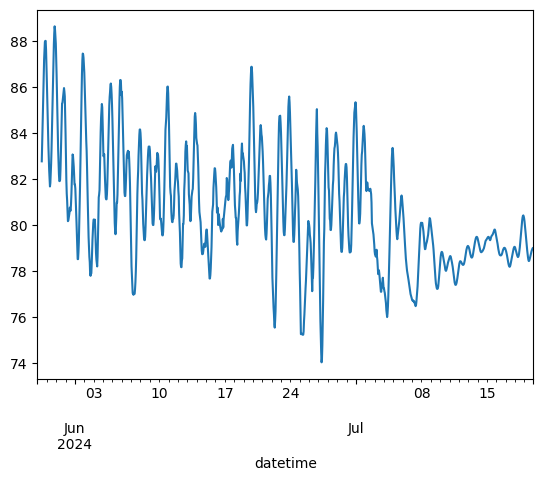

In [30]:
data['temp_MA'] = data['temp'].rolling(window=12).mean()
data.set_index('datetime')['temp_MA'].plot()
plt.show()


In [43]:
# Create lag features for temperature and other relevant columns
for lag in range(1, 4):  # create lag features up to lag 3
    data[f'temp_lag_{lag}'] = data['temp'].shift(lag)
    data[f'feelslike_lag_{lag}'] = data['feelslike'].shift(lag)
    data[f'humidity_lag_{lag}'] = data['humidity'].shift(lag)
    data[f'precip_lag_{lag}'] = data['precip'].shift(lag)

# Drop rows with NaN values created due to lagging
data = data.dropna()

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model
model = SARIMAX(data['temp'],
                exog=data[['feelslike', 'humidity', 'precip', 'windgust', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility']],
                order=(5,1,0),
                seasonal_order=(1,1,1,12))

# Fit the model
model_fit = model.fit(disp=False)
print(model_fit.summary())

# Forecasting
forecast_steps = 10
forecast = model_fit.get_forecast(steps=forecast_steps, exog=data[['feelslike', 'humidity', 'precip', 'windgust', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility']].tail(forecast_steps))
forecast_values = forecast.predicted_mean
print(forecast_values)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                 temp   No. Observations:                 1258
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -849.619
Date:                              Thu, 04 Jul 2024   AIC                           1731.238
Time:                                      23:58:59   BIC                           1813.268
Sample:                                           0   HQIC                          1762.082
                                             - 1258                                         
Covariance Type:                                opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
feelslike            0.2987      0.003    105.771      0.000       0.293       0.304
h

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Fit the model on the training set
model_fit = model.fit(disp=False)

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=test[['feelslike', 'humidity', 'precip', 'windgust', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility']])

# Calculate error metrics
mae = mean_absolute_error(test['temp'], predictions)
rmse = np.sqrt(mean_squared_error(test['temp'], predictions))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error: 0.13423851287710387
Root Mean Squared Error: 0.19451587085035701


In [50]:
# Define thresholds for "floody" conditions
precip_threshold = data['precip'].quantile(0.75)  # Top 25% of precipitation values
humidity_threshold = data['humidity'].quantile(0.75)  # Top 25% of humidity values
visibility_threshold = data['visibility'].quantile(0.25)  # Bottom 25% of visibility values

# Identify "floody" days
floody_days = data[
    (data['precip'] >= precip_threshold) &
    (data['humidity'] >= humidity_threshold) &
    (data['visibility'] <= visibility_threshold)
]

# Display the "floody" days
print(floody_days[['datetime', 'precip', 'humidity', 'visibility']])


                datetime  precip  humidity  visibility
84   2024-05-31 12:00:00   0.000     94.23         5.0
85   2024-05-31 13:00:00   0.669     98.56         5.0
86   2024-05-31 14:00:00   0.000     88.99         5.0
99   2024-06-01 03:00:00   0.000     94.23         5.0
100  2024-06-01 04:00:00   0.000     97.96         4.3
...                  ...     ...       ...         ...
953  2024-07-06 17:00:00   0.146     92.47         2.4
954  2024-07-06 18:00:00   0.165     91.37         2.6
955  2024-07-06 19:00:00   0.118     91.36         3.3
1017 2024-07-09 09:00:00   0.091     89.20         2.8
1019 2024-07-09 11:00:00   0.094     89.73         3.0

[209 rows x 4 columns]
